In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta

In [3]:
from PFNExperiments.LatentFactorModels.GenerativeModels.Clustering.GMMs import make_gmm_program_univariate, make_gmm_program_univariate_batched
from PFNExperiments.LatentFactorModels.GenerativeModels.LatenFactorModel_abstract import return_only_x

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [4]:
N = 10
P = 4
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [5]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n", curriculum.constant_scheduler(N)),
    ("p", curriculum.constant_scheduler(P)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("a1", curriculum.constant_scheduler(5.0)),
    ("b1", curriculum.constant_scheduler(2.0)),
    ("dirichlet_beta", curriculum.constant_scheduler(1.0)),
    ("lambda1", curriculum.constant_scheduler(3.0))
])
#curriculum.plot_all_schedules()

In [6]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_gmm_program_univariate_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [7]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [8]:
sample_batch = next(iter(epoch_loader[0][0]))

####################################################################################################
Epoch 0


100%|██████████| 10/10 [00:00<00:00, 30.19it/s]


{'X': {'mean': tensor(-0.0052), 'variance': tensor(3.1770), 'min': tensor(-14.4586), 'max': tensor(17.0177), 'mean_mean': tensor([-0.0052]), 'variance_mean': tensor([2.0302]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.2587), 'variance': tensor(1.4676), 'min': tensor(-13.2166), 'max': tensor(13.2042), 'mean_mean': tensor(0.2587), 'variance_mean': tensor(1.5309), 'min_mean': None, 'max_mean': None}}
Statistics for phi:
Mean: tensor([0.2547, 0.2477, 0.2534, 0.2442])
Variance: tensor([0.0390, 0.0375, 0.0375, 0.0366])
Min: tensor([3.0588e-04, 1.1136e-04, 1.2985e-04, 3.5006e-05])
Max: tensor([0.9187, 0.9414, 0.9563, 0.9153])
Mean of means: 0.25
Mean of variances: 0.050221703946590424
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([ 0.0217,  0.0364,  0.0274, -0.0195])
Variance: tensor([2.8320, 2.8366, 2.7315, 3.0004])
Min: tensor([-13.2166,  -8.1647,  -8.3023, -11.8452])
Max: tensor([ 9.5945, 13.2042, 10.8172, 10.8324])
Mean of means: 0.01

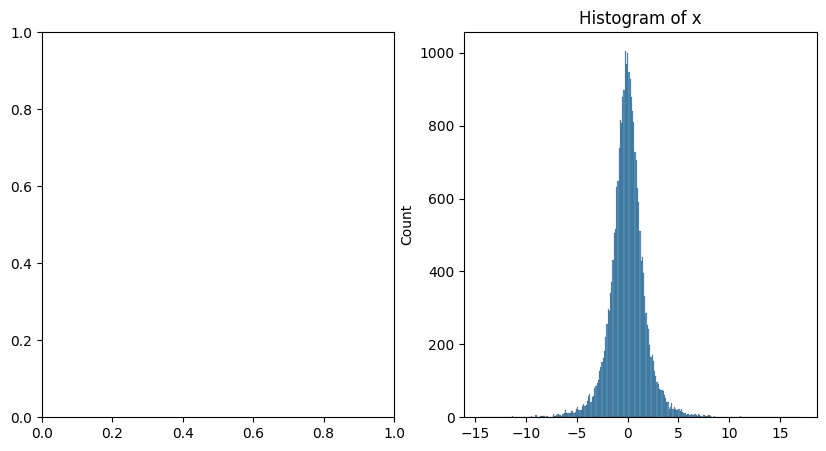

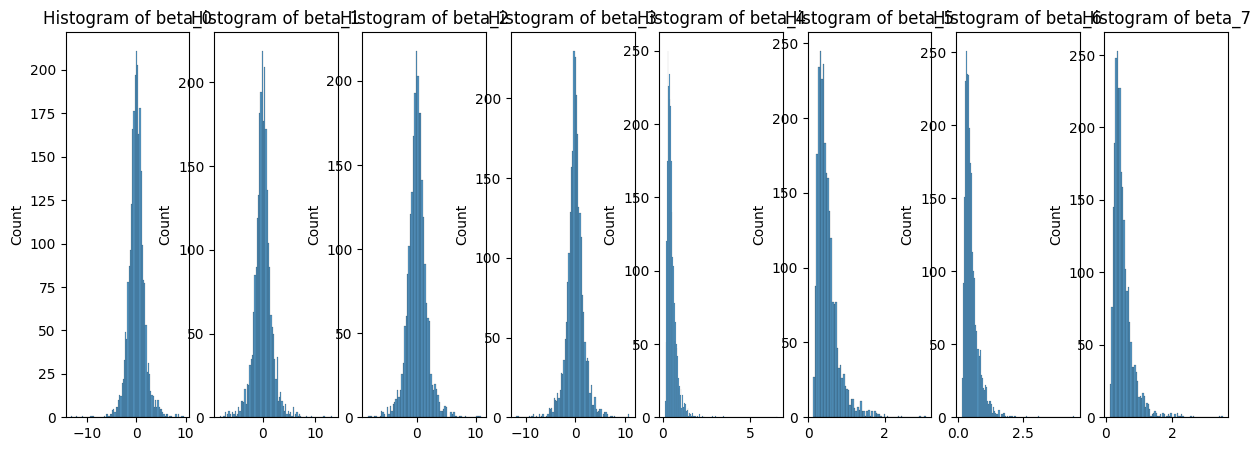

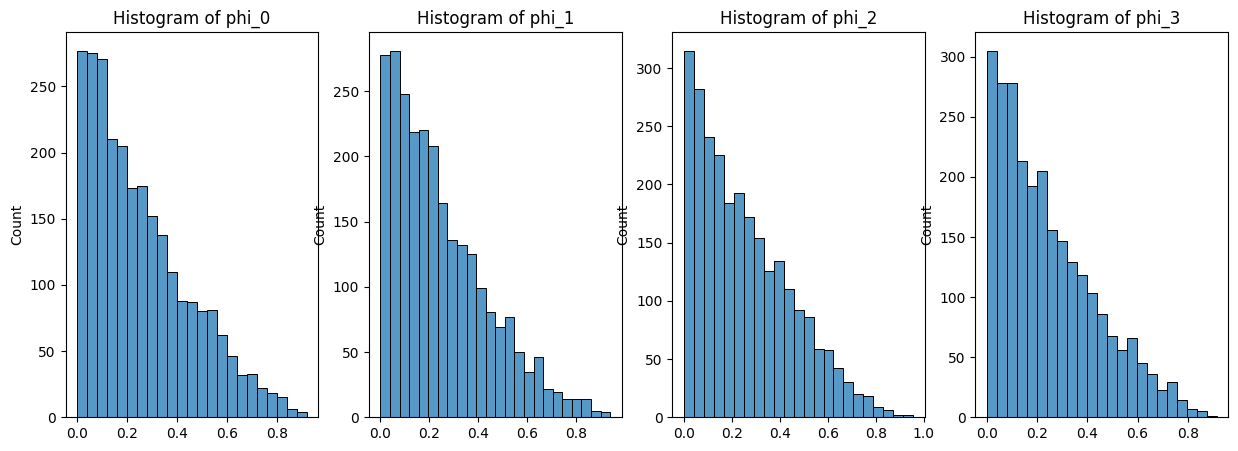

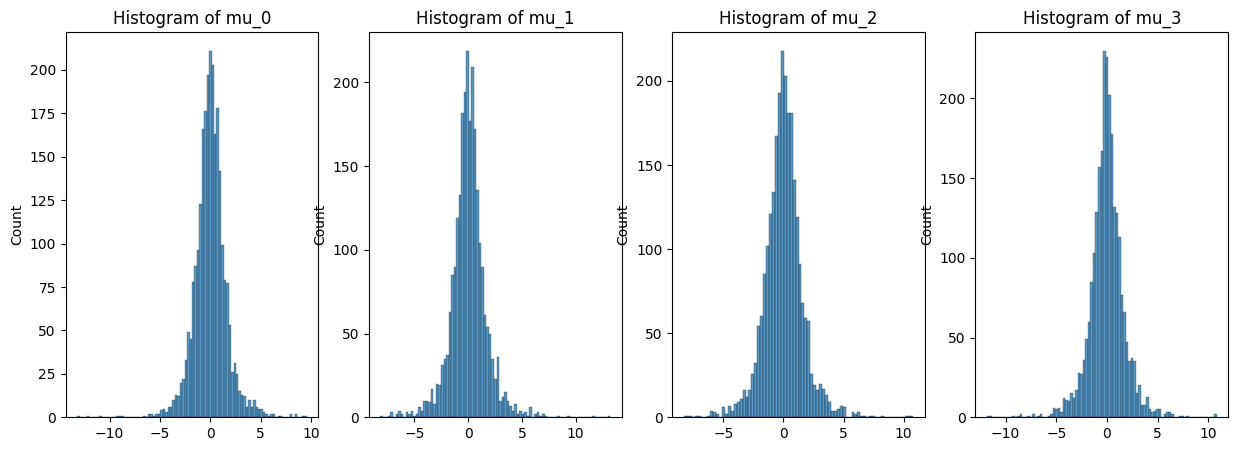

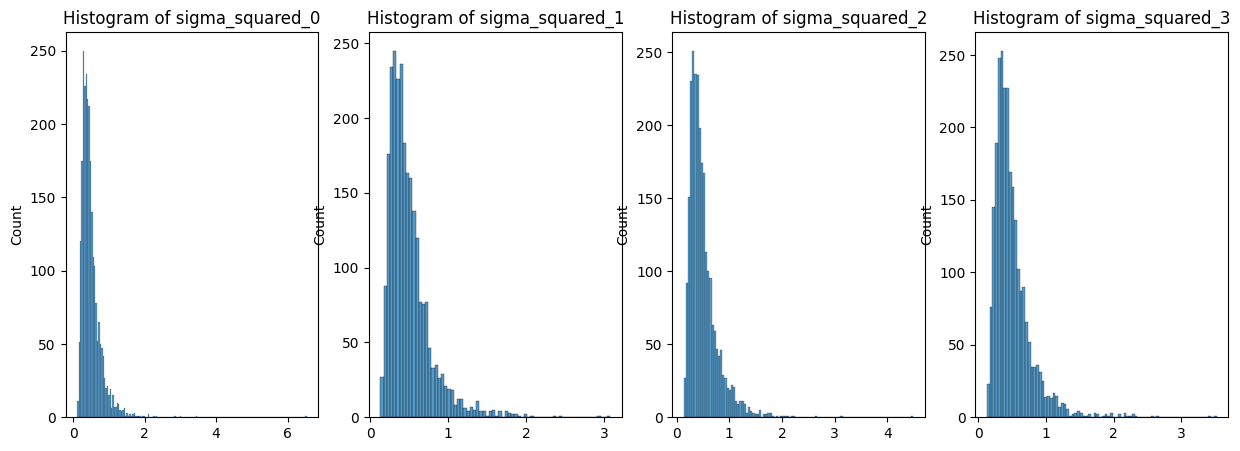

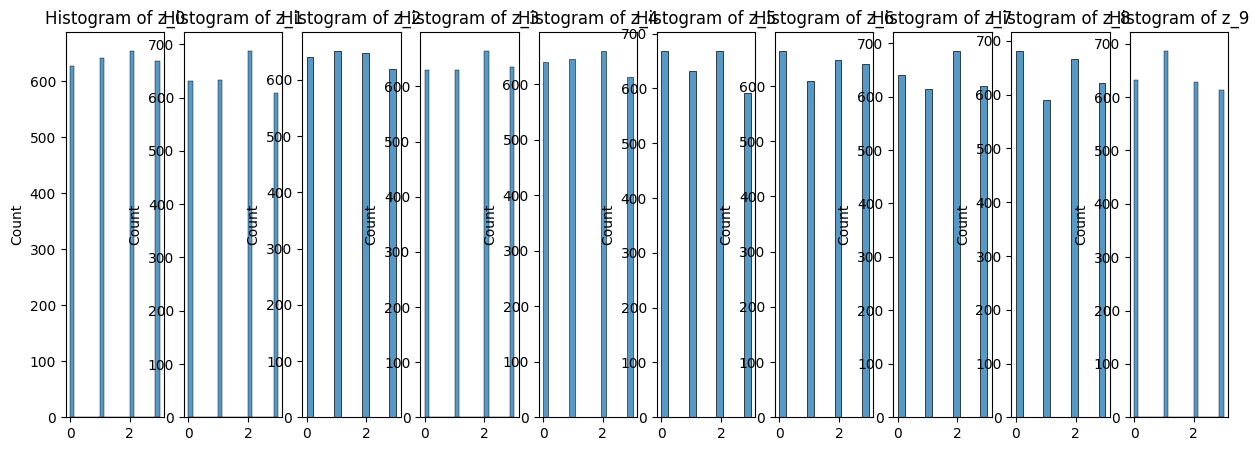

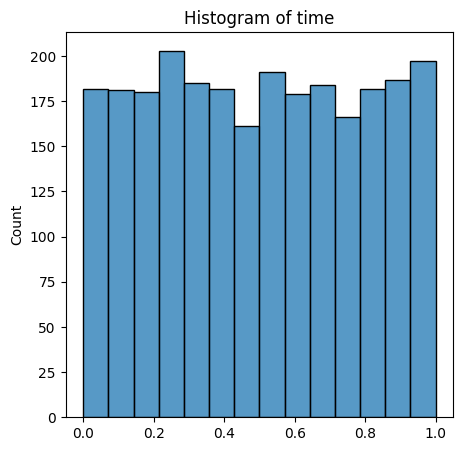

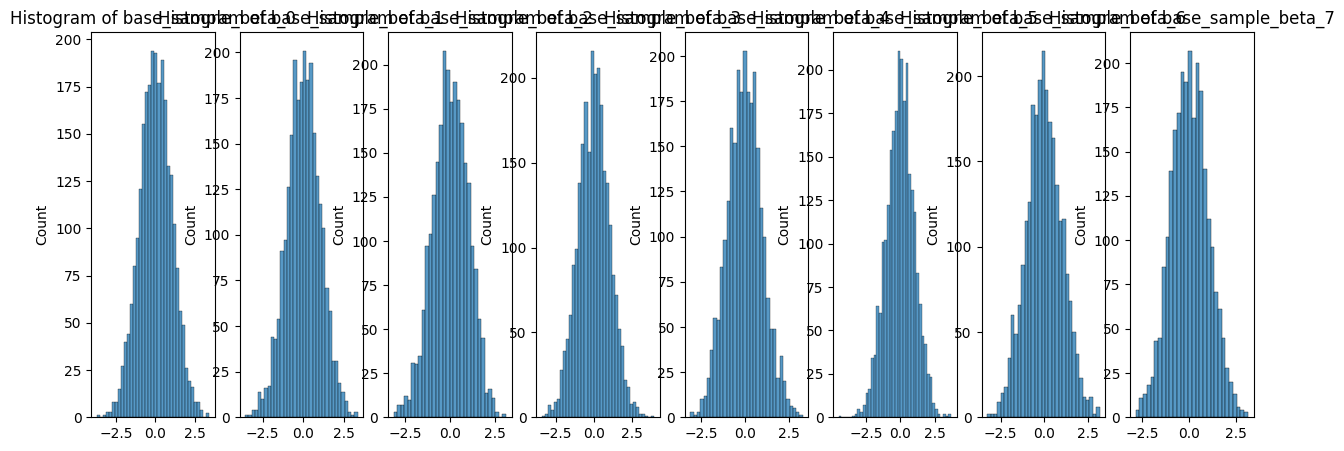

####################################################################################################
Epoch 99


100%|██████████| 10/10 [00:00<00:00, 81.65it/s]

{'X': {'mean': tensor(-0.0415), 'variance': tensor(3.3049), 'min': tensor(-33.4659), 'max': tensor(12.8574), 'mean_mean': tensor([-0.0415]), 'variance_mean': tensor([2.1429]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.2346), 'variance': tensor(1.5352), 'min': tensor(-29.7079), 'max': tensor(15.0488), 'mean_mean': tensor(0.2346), 'variance_mean': tensor(1.6313), 'min_mean': None, 'max_mean': None}}
Statistics for phi:
Mean: tensor([0.2502, 0.2521, 0.2464, 0.2514])
Variance: tensor([0.0376, 0.0375, 0.0370, 0.0386])
Min: tensor([1.8455e-04, 2.5494e-04, 7.5525e-05, 1.3254e-04])
Max: tensor([0.9457, 0.9388, 0.9606, 0.9082])
Mean of means: 0.25
Mean of variances: 0.050182320177555084
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.0737, -0.0207, -0.0106, -0.0124])
Variance: tensor([2.7762, 3.2156, 2.7854, 3.1646])
Min: tensor([-14.1743, -29.7079,  -7.4325, -17.3358])
Max: tensor([ 6.6827, 10.8396,  8.6752, 15.0488])
Mean of means: -0.0

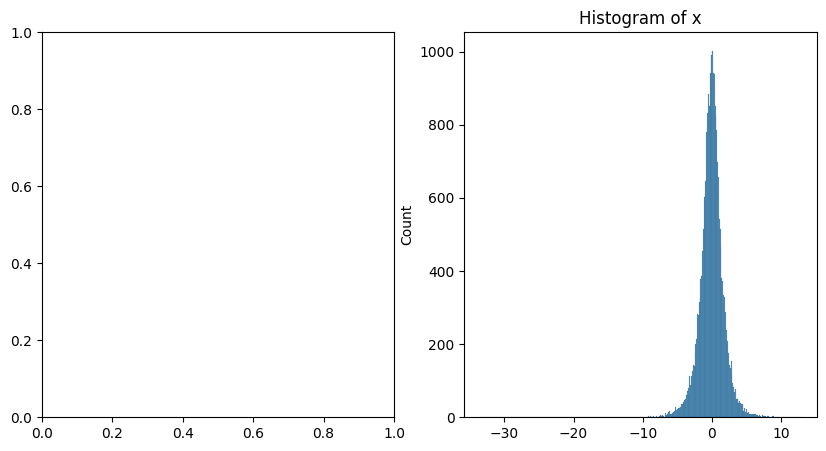

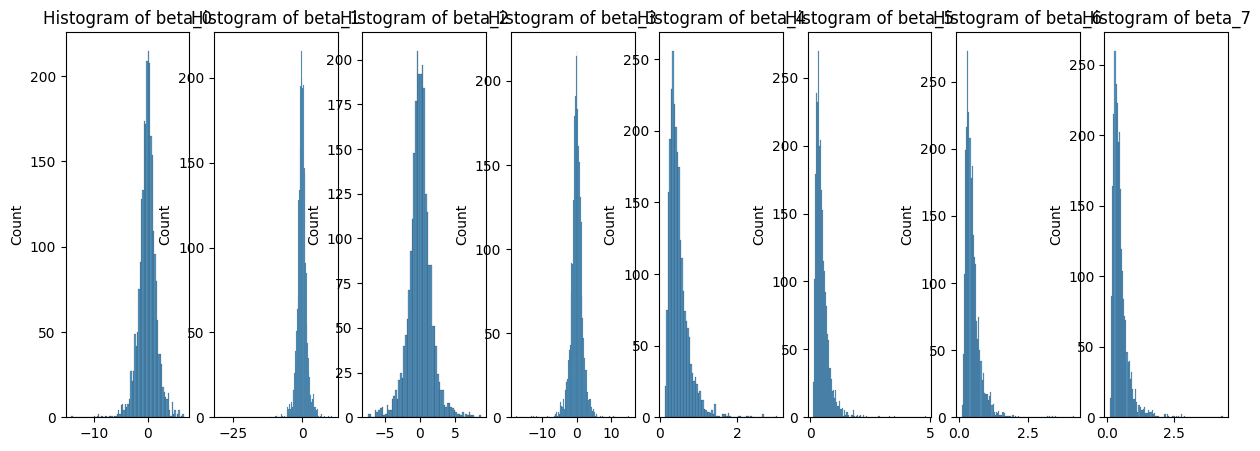

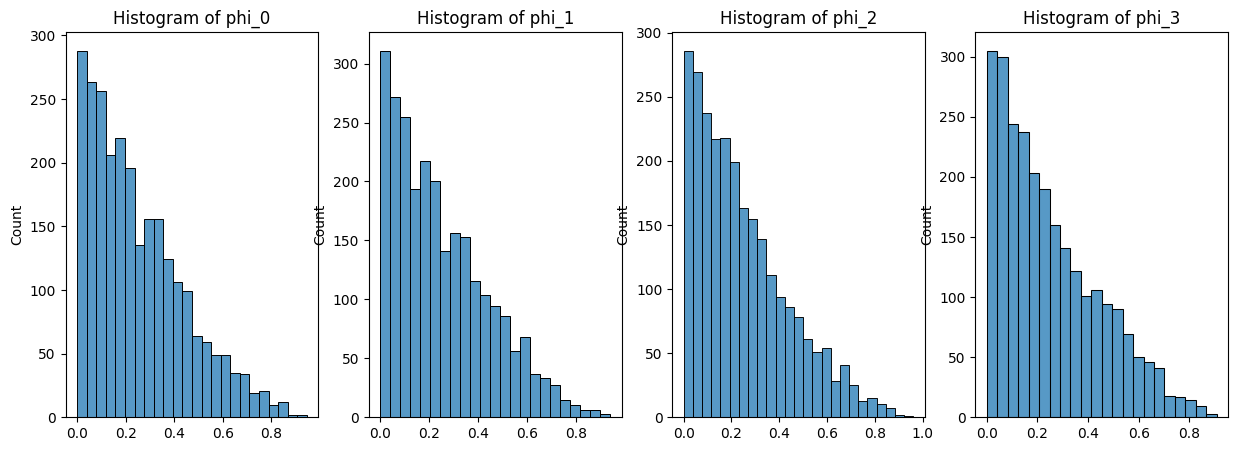

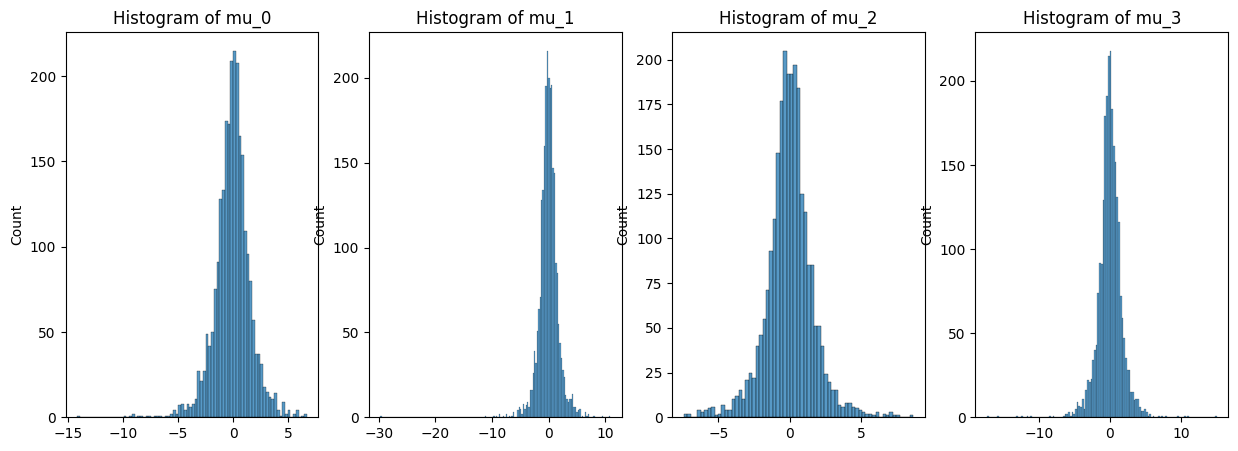

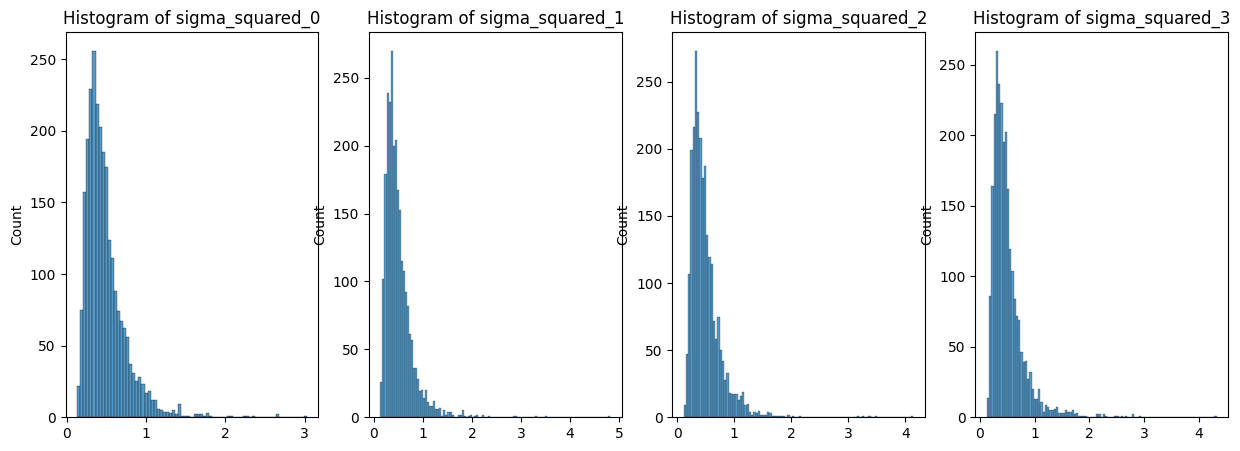

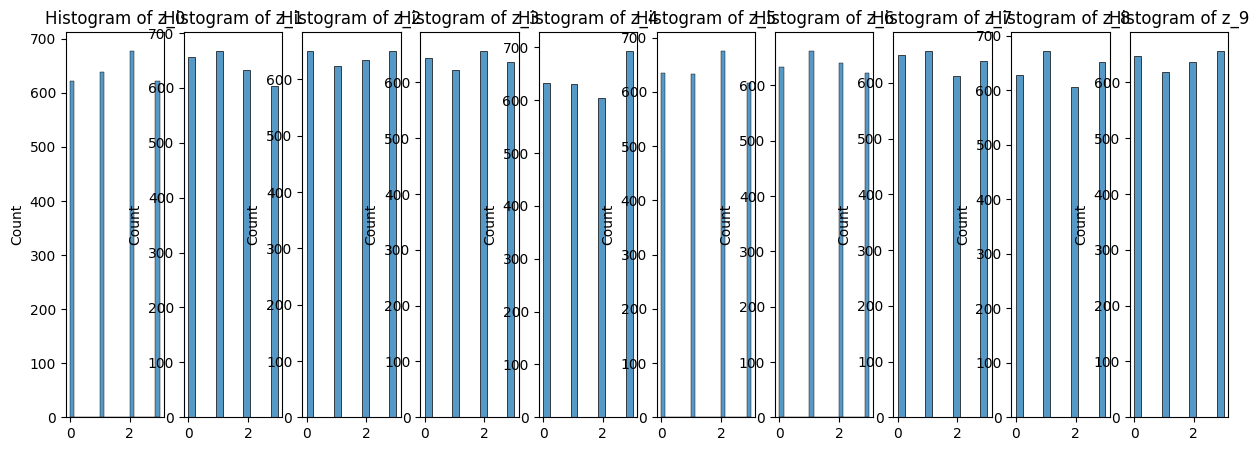

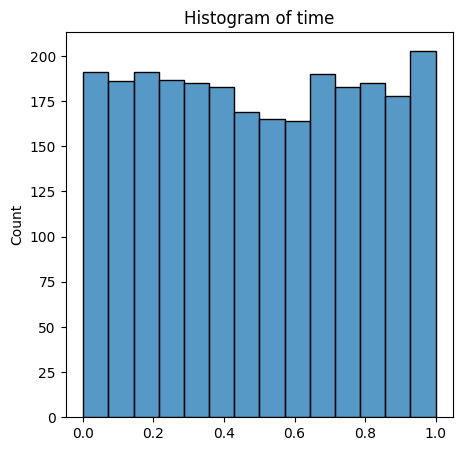

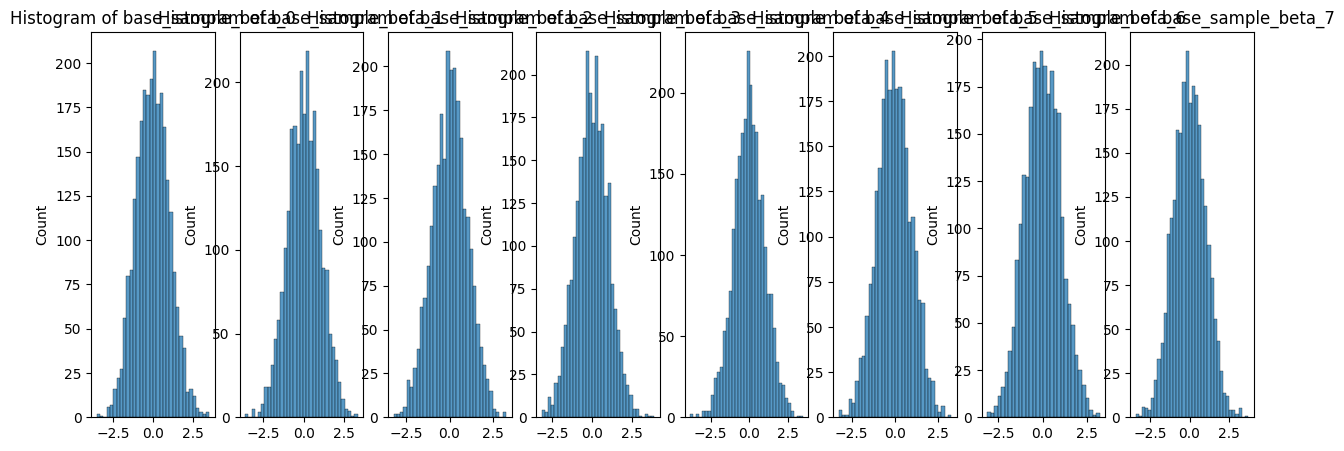

[{'X': {'mean': tensor(-0.0052),
   'variance': tensor(3.1770),
   'min': tensor(-14.4586),
   'max': tensor(17.0177),
   'mean_mean': tensor([-0.0052]),
   'variance_mean': tensor([2.0302]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.2587),
   'variance': tensor(1.4676),
   'min': tensor(-13.2166),
   'max': tensor(13.2042),
   'mean_mean': tensor(0.2587),
   'variance_mean': tensor(1.5309),
   'min_mean': None,
   'max_mean': None}},
 {'X': {'mean': tensor(-0.0415),
   'variance': tensor(3.3049),
   'min': tensor(-33.4659),
   'max': tensor(12.8574),
   'mean_mean': tensor([-0.0415]),
   'variance_mean': tensor([2.1429]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.2346),
   'variance': tensor(1.5352),
   'min': tensor(-29.7079),
   'max': tensor(15.0488),
   'mean_mean': tensor(0.2346),
   'variance_mean': tensor(1.6313),
   'min_mean': None,
   'max_mean': None}}]

In [9]:
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 10
)

In [10]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [11]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

dict_keys(['phi', 'mu', 'sigma_squared', 'z', 'x', 'beta', 'time', 'base_sample_beta'])

In [12]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([1024, 10, 1]), torch.Size([1024, 8]))

In [13]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 16,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [14]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [15]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [16]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [17]:
trainer.validate()

100%|██████████| 49/49 [00:13<00:00,  3.76it/s]


{'loss_mean': 2.8962602615356445,
 'loss_median': 2.8918588161468506,
 'loss_std': 0.09637542068958282}

In [18]:
r = trainer.train()

Curriculum parameters: {'n': 10, 'p': 4, 'batch_size': 1024, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 1.0, 'lambda1': 3.0} at iteration 0


  1%|          | 3/244 [00:01<02:38,  1.52it/s]


KeyboardInterrupt: 

In [19]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (2*P,),
    n_samples=1000,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 1e-1,
    rtol = 1e-1,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_gmm_program_univariate(**benchmark_params_ppgrogram)

pprogram1_x = return_only_x(pprogram1)



params for pprogram: {'n': 10, 'p': 4, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 1.0, 'lambda1': 3.0}


In [20]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [21]:
x_test.shape

torch.Size([1024, 10, 1])

In [22]:
full_model.sample_posterior(x_test[0])

0it [00:00, ?it/s]


{'beta': tensor([[ 0.2719, -0.7207, -1.0699,  ..., -0.5934,  0.8387, -0.8805],
         [-1.6775, -1.8487,  1.4028,  ..., -0.6160,  0.7190,  0.7447],
         [ 1.4513,  1.1085,  0.5293,  ...,  0.0316, -0.1207,  0.1719],
         ...,
         [-1.0304, -0.5037,  0.3168,  ...,  0.3929, -0.6204,  0.1504],
         [ 1.3311,  0.1456,  0.4205,  ...,  0.3045,  2.4413,  0.6783],
         [ 0.7361, -1.1226,  1.0799,  ...,  0.9779,  0.4548, -0.9052]],
        grad_fn=<CatBackward0>),
 'X': tensor([[ 0.1199],
         [ 0.2814],
         [ 0.1315],
         [ 0.2562],
         [ 0.3295],
         [ 0.1590],
         [ 0.0901],
         [ 1.0266],
         [-0.1448],
         [-0.2878]]),
 'y': None}

In [31]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1_x,
    n_samples=500,
    n_warmup=500
)

models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

In [53]:
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader = trainer.testset,
    comparison_models= models[1:],
    n_evaluation_cases=3,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta
)

In [54]:
evaluation.run_evaluation()

(tensor([[2.1007],
        [1.5853],
        [1.8341],
        [1.7033],
        [0.9893],
        [1.0809],
        [1.4646],
        [1.6951],
        [0.2537],
        [1.7095]]), None)



0it [00:00, ?it/s]
Sampling posterior:   0%|          | 0/3 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [34]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [61]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_univariate_GMM import Preprocessor_GMM_univariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_univariate(
        N_datapoints = N,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [62]:
datasets[0]["x"].shape

torch.Size([10, 1])

In [63]:
comparison_models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

In [64]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = comparison_models[1:3],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta
)

In [65]:
eval.run_evaluation()

(tensor([[ 1.5091],
        [-0.8021],
        [ 0.6934],
        [-1.2100],
        [ 0.5574],
        [ 1.2372],
        [-0.1224],
        [-0.2583],
        [-0.1224],
        [-1.4819]]), None)



0it [00:00, ?it/s]


(tensor([[ 2.8460],
        [-0.3162],
        [-0.3162],
        [-0.3162],
        [-0.3162],
        [-0.3162],
        [-0.3162],
        [-0.3162],
        [-0.3162],
        [-0.3162]]), None)



0it [00:00, ?it/s]
Sampling posterior:  50%|█████     | 1/2 [00:02<00:02,  2.03s/it]


KeyboardInterrupt: 